# Computational modeling in behavioral science

In [13]:
%reset -f
import os, sys, glob, itertools, logging, warnings, time, math, re, json, math, csv, random
import pandas as pd
warnings.simplefilter("ignore")
if not sys.warnoptions: os.environ["PYTHONWARNINGS"] = "ignore"
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
InteractiveShell.ast_node_interactivity = 'last'
RST, RED, GRN, BLU, YLW = "\x1b[0m", "\x1b[31m", "\x1b[32m", "\x1b[34m", "\x1b[33m"

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.transforms import Affine2D
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from matplotlib.collections import PathCollection

from scipy import optimize
from itertools import product
import statsmodels.api as sm
import numpy as np

def mle_rescorla_wagner(parms, states, rewards, choices):
    # Rescorla-Wagner Model (RW) (Rescorla & Wagner, 1972; Sutton & Barto, 1998)
    beta, alpha = parms[0], parms[1]
    n_trial = len(states)
    log_lik = [] #container to store the values
    V = np.zeros((2, n_trial+1), dtype=float)
    for t in range(n_trial):
        a_t, r_t = choices[t], rewards[t]
        dV = V[1, t] - V[0, t]
        cp_t = 1/(1+ np.exp(-beta*dV))
        log_lik_t = a_t * np.log(cp_t) + (1 - a_t) * np.log(1 - cp_t)
        log_lik.append(log_lik_t) #store current trial log-lik value
        pe = r_t - V[a_t, t]
        V[a_t, t+1] = V[a_t, t] + alpha*pe
        V[1-a_t, t+1] = V[1-a_t, t]
    neg_loglik = -np.nansum(log_lik)  #Add all the values and calculate the negative
    return neg_loglik

def mle_rescorla_wagner_asym(parms, states, rewards, choices):
    # Rescorla-Wagner Model (RW) (Rescorla & Wagner, 1972; Sutton & Barto, 1998)
    beta, alphap, alphan = parms[0], parms[1], parms[2]
    n_trial = len(states)
    log_lik = [] #container to store the values
    V = np.zeros((2, n_trial+1), dtype=float)
    for t in range(n_trial):
        a_t, r_t = choices[t], rewards[t]
        dV = V[1, t] - V[0, t]
        cp_t = 1/(1+ np.exp(-beta*dV))
        log_lik_t = a_t * np.log(cp_t) + (1 - a_t) * np.log(1 - cp_t)
        log_lik.append(log_lik_t) #store current trial log-lik value
        pe = r_t - V[a_t, t]
        alpha = alphap if pe>=0 else alphan
        V[a_t, t+1] = V[a_t, t] + alpha*pe
        V[1-a_t, t+1] = V[1-a_t, t]
    neg_loglik = -np.nansum(log_lik)  #Add all the values and calculate the negative
    return neg_loglik

def pred_rescorla_wagner_asym(parms, states, rewards, choices):
    # Rescorla-Wagner Model (RW) (Rescorla & Wagner, 1972; Sutton & Barto, 1998)
    beta, alphap, alphan = parms[0], parms[1], parms[2]
    n_trial = len(states)
    choices_prob = [] #container to store the values
    V = np.zeros((2, n_trial+1), dtype=float)
    for t in range(n_trial):
        #current trial choice and reward
        a_t, r_t = choices[t], rewards[t]

        dV = V[1, t] - V[0, t] #Value difference
        #Sigmoid function
        cp_t = 1/(1+ np.exp(-beta*dV)) #choice probability of RIGHT option
        choices_prob.append(cp_t) #store current trial choice probability

        pe = r_t - V[a_t, t] #reward prediction error
        alpha = alphap if pe>=0 else alphan
        # Value update for chosen option with delta rule
        V[a_t, t+1] = V[a_t, t] + alpha*pe
        # Value update for unchosen option (keep old Values)
        V[1-a_t, t+1] = V[1-a_t, t]

    choices_pred = (np.asarray(choices_prob) > 0.5).astype(int)
    return choices_pred

def pred_rescorla_wagner(parms, states, rewards, choices):
    # Rescorla-Wagner Model (RW) (Rescorla & Wagner, 1972; Sutton & Barto, 1998)
    beta, alpha = parms[0], parms[1]
    n_trial = len(states)
    choices_prob = [] #container to store the values
    V = np.zeros((2, n_trial+1), dtype=float)
    for t in range(n_trial):
        #current trial choice and reward
        a_t, r_t = choices[t], rewards[t]

        dV = V[1, t] - V[0, t] #Value difference
        #Sigmoid function
        cp_t = 1/(1+ np.exp(-beta*dV)) #choice probability of RIGHT option
        choices_prob.append(cp_t) #store current trial choice probability

        pe = r_t - V[a_t, t] #reward prediction error
        # Value update for chosen option with delta rule
        V[a_t, t+1] = V[a_t, t] + alpha*pe
        # Value update for unchosen option (keep old Values)
        V[1-a_t, t+1] = V[1-a_t, t]

    choices_pred = (np.asarray(choices_prob) > 0.5).astype(int)
    return choices_pred


def vars_rescorla_wagner(parms, states, rewards, choices):
    # Rescorla-Wagner Model (RW) (Rescorla & Wagner, 1972; Sutton & Barto, 1998)
    beta, alpha = parms[0], parms[1]
    n_trial = len(states)
    choices_prob = [] #container to store the values
    delta_value = [] #container to store the values
    pred_error = [] #container to store the values
    V = np.zeros((2, n_trial+1), dtype=float)
    for t in range(n_trial):
        #current trial choice and reward
        a_t, r_t = choices[t], rewards[t]

        dV = V[1, t] - V[0, t] #Value difference
        #Sigmoid function
        cp_t = 1/(1+ np.exp(-beta*dV)) #choice probability of RIGHT option

        pe = r_t - V[a_t, t] #reward prediction error
        # Value update for chosen option with delta rule
        V[a_t, t+1] = V[a_t, t] + alpha*pe
        # Value update for unchosen option (keep old Values)
        V[1-a_t, t+1] = V[1-a_t, t]

        choices_prob.append(cp_t) #store current trial choice probability
        delta_value.append(dV) #store current trial choice probability
        pred_error.append(pe) #store current trial choice probability

    choices_pred = (np.asarray(choices_prob) > 0.5).astype(int)
    return choices_pred, choices_prob, pred_error, delta_value

def vars_rescorla_wagner_asym(parms, states, rewards, choices):
    # Rescorla-Wagner Model (RW) (Rescorla & Wagner, 1972; Sutton & Barto, 1998)
    beta, alphap, alphan = parms[0], parms[1], parms[2]
    n_trial = len(states)
    choices_prob = [] #container to store the values
    delta_value = [] #container to store the values
    pred_error = [] #container to store the values
    V = np.zeros((2, n_trial+1), dtype=float)
    for t in range(n_trial):
        #current trial choice and reward
        a_t, r_t = choices[t], rewards[t]

        dV = V[1, t] - V[0, t] #Value difference
        #Sigmoid function
        cp_t = 1/(1+ np.exp(-beta*dV)) #choice probability of RIGHT option

        pe = r_t - V[a_t, t] #reward prediction error
        alpha = alphap if pe>=0 else alphan
        # Value update for chosen option with delta rule
        V[a_t, t+1] = V[a_t, t] + alpha*pe
        # Value update for unchosen option (keep old Values)
        V[1-a_t, t+1] = V[1-a_t, t]

        choices_prob.append(cp_t) #store current trial choice probability
        delta_value.append(dV) #store current trial choice probability
        pred_error.append(pe) #store current trial choice probability

    choices_pred = (np.asarray(choices_prob) > 0.5).astype(int)
    return choices_pred, choices_prob, pred_error, delta_value

def sim_rescorla_wagner_asym(parms, states, rewards, choices, seed):
    np.random.seed(seed)
    # Rescorla-Wagner Model (RW) (Rescorla & Wagner, 1972; Sutton & Barto, 1998)
    beta, alphap, alphan = parms[0], parms[1], parms[2]
    n_trial = len(states)
    choices_prob = [] #container to store the values
    V = np.zeros((2, n_trial+1), dtype=float)
    sim_choices, sim_rewards = np.zeros((n_trial), dtype=int), np.zeros((n_trial), dtype=int)
    rmatrix = np.array([0.2, 0.8])

    for t in range(n_trial):

        dV = V[1, t] - V[0, t] #Value difference
        #Sigmoid function
        cp_t = 1/(1+ np.exp(-beta*dV)) #choice probability of RIGHT option
        choices_prob.append(cp_t) #store current trial choice probability

        #current trial choice and reward
        a_t = np.random.choice([0, 1], p=[1-cp_t, cp_t])
        r_t = np.random.choice([0, 1], p=[1-rmatrix[a_t], rmatrix[a_t]])
        sim_choices[t], sim_rewards[t] = a_t, r_t

        pe = r_t - V[a_t, t] #reward prediction error
        alpha = alphap if pe>=0 else alphan
        # Value update for chosen option with delta rule
        V[a_t, t+1] = V[a_t, t] + alpha*pe
        # Value update for unchosen option (keep old Values)
        V[1-a_t, t+1] = V[1-a_t, t]

    return sim_choices, sim_rewards


def sim_rescorla_wagner(parms, states, rewards, choices, seed):
    np.random.seed(seed)
    # Rescorla-Wagner Model (RW) (Rescorla & Wagner, 1972; Sutton & Barto, 1998)
    beta, alpha = parms[0], parms[1]
    n_trial = len(states)
    choices_prob = [] #container to store the values
    V = np.zeros((2, n_trial+1), dtype=float)
    sim_choices, sim_rewards = np.zeros((n_trial), dtype=int), np.zeros((n_trial), dtype=int)
    rmatrix = np.array([0.2, 0.8])

    for t in range(n_trial):

        dV = V[1, t] - V[0, t] #Value difference
        #Sigmoid function
        cp_t = 1/(1+ np.exp(-beta*dV)) #choice probability of RIGHT option
        choices_prob.append(cp_t) #store current trial choice probability

        #current trial choice and reward
        a_t = np.random.choice([0, 1], p=[1-cp_t, cp_t])
        r_t = np.random.choice([0, 1], p=[1-rmatrix[a_t], rmatrix[a_t]])
        sim_choices[t], sim_rewards[t] = a_t, r_t

        pe = r_t - V[a_t, t] #reward prediction error
        # Value update for chosen option with delta rule
        V[a_t, t+1] = V[a_t, t] + alpha*pe
        # Value update for unchosen option (keep old Values)
        V[1-a_t, t+1] = V[1-a_t, t]

    return sim_choices, sim_rewards

def plot_pred_com_model_ewa(choices, rewards, choices_pred0, choices_pred1, subject, model0, model1):
    sz = (6.8, 2.9)
    trials = np.arange(len(choices))
    fig, ax = plt.subplots(figsize=sz)

    # rewards = (rewards/2).astype(int)
    rewards = (rewards).astype(int)
    ewa_rewards = pd.Series(rewards.tolist()).ewm(span=5, adjust=False).mean().values.tolist()

    ewa_choices = pd.Series(choices.tolist()).ewm(span=5, adjust=False).mean().values.tolist()
    ewa_choices_pred0 = pd.Series(choices_pred0.tolist()).ewm(span=5, adjust=False).mean().values.tolist()
    ewa_choices_pred1 = pd.Series(choices_pred1.tolist()).ewm(span=5, adjust=False).mean().values.tolist()

    # ax.plot(trials, ewa_choices_pred0, label="ewa lg ", color="green",linestyle=":", linewidth=1.0, alpha=0.9)

    ax.plot(trials, choices, label="data", color="black",linestyle="-", linewidth=1.0, alpha=0.5)
    ax.plot(trials, ewa_choices, label='ewa data', color="blue",linestyle="-", linewidth=1.0, alpha=0.7)
    ax.plot(trials, ewa_rewards, label='ewa reward', color="orange",linestyle="-", linewidth=1.0, alpha=0.7)
    ax.plot(trials, ewa_choices_pred0, label="ewa "+model0, color="green",linestyle=":", linewidth=1.0, alpha=0.9)
    ax.plot(trials, ewa_choices_pred1, label="ewa "+model1, color="red",linestyle=":", linewidth=1.0, alpha=0.9)
    ax.set_title("")
    ax.set_xlabel("Trials")
    ax.set_ylabel("Choice")

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Leyenda fuera
    ax.grid(alpha=0.4)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajuste horizontal para la leyenda

    fo = f'plot/img-{subject:02d}.png'
    # plt.savefig(fo, dpi=500)
    plt.show()
    plt.close(fig)

def plot_pred_model(choices, rewards,  choices_pred, subject, model):
    sz = (6.8, 2.9)
    trials = np.arange(len(choices_pred))
    fig, ax = plt.subplots(figsize=sz)
    ewa_choices = pd.Series(choices.tolist()).ewm(span=5, adjust=False).mean().values.tolist()
    ewa_choices_pred = pd.Series(choices_pred.tolist()).ewm(span=5, adjust=False).mean().values.tolist()
    rewards = (rewards).astype(int)
    ewa_rewards = pd.Series(rewards.tolist()).ewm(span=5, adjust=False).mean().values.tolist()

    ax.plot(trials, choices, label="data", color="black",linestyle="-", linewidth=1.0, alpha=0.5)
    ax.plot(trials, ewa_rewards, label='reward', color="red",linestyle="-", linewidth=1.0, alpha=0.7)
    ax.plot(trials, choices_pred, label=model, color="blue",linestyle="dotted", linewidth=1.0, alpha=0.7)

    ax.plot(trials, ewa_choices_pred, label="prob", color="orange",linestyle=":", linewidth=1.0, alpha=0.9)
    ax.plot(trials, ewa_choices, label="ewa choice", color="cyan",linestyle=":", linewidth=1.0, alpha=0.9)

    ax.set_title("Pred Choices Model " + model.upper())
    ax.set_xlabel("Trials")
    ax.set_ylabel("Choice")

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Leyenda fuera
    ax.grid(alpha=0.4)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajuste horizontal para la leyenda

    fo = f'plot/{model}/img-{subject:02d}.png'
    # plt.savefig(fo, dpi=500)
    plt.show()
    plt.close(fig)


def plot_vars_model(choices, rewards,  var_pred, subject, model):
    sz = (6.8, 2.9)
    trials = np.arange(len(var_pred))
    fig, ax = plt.subplots(figsize=sz)
    rewards = (rewards).astype(int)
    ewa_rewards = pd.Series(rewards.tolist()).ewm(span=5, adjust=False).mean().values.tolist()
    ewa_choices = pd.Series(choices.tolist()).ewm(span=5, adjust=False).mean().values.tolist()
    ewa_preds = pd.Series(var_pred).ewm(span=5, adjust=False).mean().values.tolist()

    ax.plot(trials, choices, label="data", color="black",linestyle="-", linewidth=1.0, alpha=0.5)
    ax.plot(trials, ewa_choices, label="ewa choice", color="blue",linestyle=":", linewidth=1.0, alpha=0.9)
    ax.plot(trials, ewa_rewards, label='reward', color="red",linestyle="-", linewidth=1.0, alpha=0.7)
    # ax.plot(trials, ewa_preds, label="ewa v", color="red",linestyle=":", linewidth=1.0, alpha=0.9)
    ax.plot(trials, var_pred, label="v", color="green",linestyle=":", linewidth=1.0, alpha=0.9)

    ax.set_title("Model VARS " + model.upper())
    ax.set_xlabel("Trials")
    ax.set_ylabel("Vars")

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Leyenda fuera
    ax.grid(alpha=0.4)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajuste horizontal para la leyenda

    fo = f'plot/{model}/img-{subject:02d}.png'
    # plt.savefig(fo, dpi=500)
    plt.show()
    plt.close(fig)



[14, 15, 16, 17, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 76, 77, 78, 79, 80, 81, 82, 83, 108, 109, 110, 111, 112, 113, 114, 115, 124, 125, 126, 127, 142, 143, 144, 145, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 204, 205, 206, 207, 208, 209, 210, 211, 236, 237, 238, 239, 240, 241, 242, 243, 252, 253, 254, 255, 270, 271, 272, 273, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 332, 333, 334, 335, 336, 337, 338, 339, 364, 365, 366, 367, 368, 369, 370, 371, 380, 381, 382, 383]
192
SUBJECT      : 174 
choices = [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

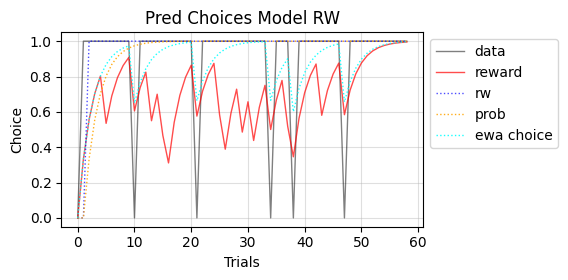

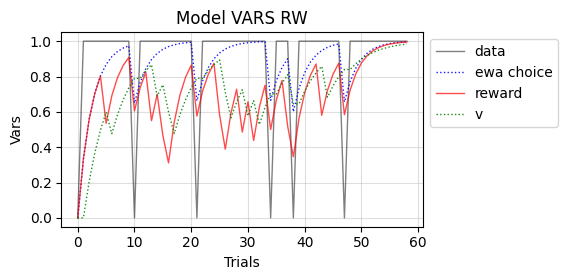

In [14]:


np.set_printoptions(suppress=True)
# url = 'https://raw.githubusercontent.com/rgarciatest/behav_modeling_test/refs/heads/main/behav_data_30.csv'
# url = 'https://raw.githubusercontent.com/rgarciatest/behav_modeling_test/refs/heads/main/behav_data.csv'
url = 'https://raw.githubusercontent.com/rgarciatest/behav_modeling_test/refs/heads/main/behav_data_60.csv'

data = pd.read_csv(url, index_col=False)
subjects = data["subj"].unique().tolist()
print(subjects)
print(len(subjects))
subject = np.random.choice(subjects, size=1)[0]
df = data.loc[data['subj']==subject].reset_index(drop=True)

states = df['states'].astype(int).values
choices = df['choices'].astype(int).values
rewards = df['rewards'].astype(int).values
# rewards = np.asarray( rewards.tolist()[:int(int(len(rewards.tolist())) /2)] + ((1-rewards)*1).tolist()[int(int(len(rewards.tolist())) /2):], dtype=int)

#RW
beta = 0.1
alpha = 0.0
parms1 = [beta, alpha]
bounds1 = [(0.01, 30.0), (0.0, 1.0)]
opt1 = optimize.minimize(mle_rescorla_wagner, parms1, args=(states, rewards, choices), method='L-BFGS-B', bounds=bounds1)
parms1, nll1 = opt1.x, opt1.fun
bic1 = -2 * -nll1 + len(parms1) * np.log(len(states))
choices_pred1 = pred_rescorla_wagner(parms1, states, rewards, choices)
choices_pred1, choices_prob1, pred_error1, delta_value1 = vars_rescorla_wagner(parms1, states, rewards, choices)

#RW ASYM
beta = 0.1
alphap = 0.0
alphan = 0.0
parms2 = [beta, alphap, alphan]
bounds2 = [(0.01, 30.0), (0.0, 1.0), (0.0, 1.0)]
opt2 = optimize.minimize(mle_rescorla_wagner_asym, parms2, args=(states, rewards, choices), method='L-BFGS-B', bounds=bounds2)
parms2, nll2 = opt2.x, opt2.fun
bic2 = -2 * -nll2 + len(parms2) * np.log(len(states))
choices_pred2 = pred_rescorla_wagner(parms2, states, rewards, choices)
choices_pred2, choices_prob2, pred_error2, delta_value2 = vars_rescorla_wagner_asym(parms2, states, rewards, choices)

print(YLW+'SUBJECT      :', subject,RST)
print('choices =',choices.tolist())
print('rewards =',rewards.tolist())
print()

seed = 42
seed = None
np.random.seed(seed)
dbic = np.argmin(np.array([bic1,bic2]))
if not bool(dbic):
    true_parms1 = parms1
    sim_choices1, sim_rewards1 = sim_rescorla_wagner(true_parms1, states, rewards, choices, seed)
    opt1 = optimize.minimize(mle_rescorla_wagner, true_parms1, args=(states, sim_rewards1, sim_choices1), method='L-BFGS-B', bounds=bounds1)
    rec_parms1, nll1 = opt1.x, opt1.fun
    bic1 = -2 * -nll1 + len(rec_parms1) * np.log(len(states))

    print(GRN+"DBIC:", round(np.abs(bic2-bic1), 4),RST)
    print(GRN+'BEST MODEL RW'+RST)
    print(GRN+"parms      :", parms1.round(6).tolist(),RST)
    print(GRN+"BIC RW     :", round(bic1, 3),RST)
    print(GRN+"BIC RW ASYM:", round(bic2, 3),RST)
    print(GRN+"parms RC   :", rec_parms1.round(6).tolist(),RST)
    print()

    # choices_pred_rec1 = pred_rescorla_wagner(rec_parms1, states, sim_rewards1, sim_choices1)
    # plot_pred_model(sim_choices1, sim_rewards1, choices_pred_rec1, subject, 'rc')
    plot_pred_model(choices, rewards, choices_pred1, subject, 'rw')
    plot_vars_model(choices, rewards, delta_value1, subject, 'rw')

else:
    true_parms2 = parms2
    sim_choices2, sim_rewards2 = sim_rescorla_wagner_asym(true_parms2, states, rewards, choices, seed)
    opt2 = optimize.minimize(mle_rescorla_wagner_asym, true_parms2, args=(states, sim_rewards2, sim_choices2), method='L-BFGS-B', bounds=bounds2)
    rec_parms2, nll2 = opt2.x, opt2.fun
    bic2 = -2 * -nll2 + len(rec_parms2) * np.log(len(states))

    print(RED+"DBIC:", round(np.abs(bic2-bic1), 4),RST)
    print(RED+'BEST MODEL: RW ASYM'+RST)
    print(RED+"parms      :", parms2.round(6).tolist(),RST)
    print(RED+"BIC RW     :", round(bic1, 3),RST)
    print(RED+"BIC RW ASYM:", round(bic2, 3),RST)
    print(RED+"parms RC   :", rec_parms2.round(6).tolist(),RST)
    print()
    # choices_pred_rec2 = pred_rescorla_wagner_asym(rec_parms2, states, sim_rewards2, sim_choices2)
    # plot_pred_model(sim_choices2, sim_rewards2, choices_pred_rec2, subject, 'rc')
    plot_pred_model(choices, rewards, choices_pred2, subject, 'rw2')
    plot_vars_model(choices, rewards, delta_value2, subject, 'rw2')

# plot_pred_com_model_ewa(choices, rewards, choices_pred2, choices_pred1, subject, 'rw2', 'rw')


SUBJECT      : 183 
choices = [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1]
rewards = [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]

parms      : [0.451985, 1.0] 
NLL RW     : 39.306 



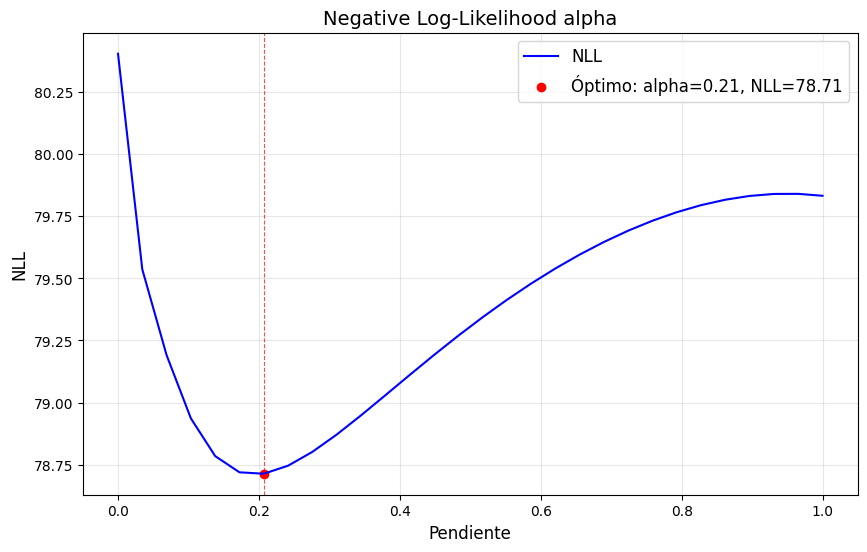

In [29]:
np.set_printoptions(suppress=True)
# url = 'https://raw.githubusercontent.com/rgarciatest/behav_modeling_test/refs/heads/main/behav_data_30.csv'
# url = 'https://raw.githubusercontent.com/rgarciatest/behav_modeling_test/refs/heads/main/behav_data.csv'
url = 'https://raw.githubusercontent.com/rgarciatest/behav_modeling_test/refs/heads/main/behav_data_60.csv'

data = pd.read_csv(url, index_col=False)
subjects = data["subj"].unique().tolist()
# print(subjects)
# print(len(subjects))
subject = np.random.choice(subjects, size=1)[0]
df = data.loc[data['subj']==subject].reset_index(drop=True)

states = df['states'].astype(int).values
choices = df['choices'].astype(int).values
rewards = df['rewards'].astype(int).values
# rewards = np.asarray( rewards.tolist()[:int(int(len(rewards.tolist())) /2)] + ((1-rewards)*1).tolist()[int(int(len(rewards.tolist())) /2):], dtype=int)

print(YLW+'SUBJECT      :', subject,RST)
print('choices =',choices.tolist())
print('rewards =',rewards.tolist())
print()


#RW
beta = 0.1
alpha = 0.0

params = [beta, alpha]
bounds = [(0.01, 30.0), (0.0, 1.0)]
opt = optimize.minimize(mle_rescorla_wagner, params, args=(states, rewards, choices), method='L-BFGS-B', bounds=bounds)
parms, nll = opt.x, opt.fun
# bic = -2 * -nll + len(parms) * np.log(len(states))
print(GRN+"parms      :", parms.round(6).tolist(),RST)
print(GRN+"NLL RW     :", round(nll, 3),RST)
# print(GRN+"BIC RW     :", round(bic, 3),RST)
print()

start, stop, scale, n = 0.0, 1.0, 2.0, 30
betas = np.cumsum(np.random.exponential(scale=scale, size=n)).tolist()
alphas = np.linspace(start, stop, n).tolist()
bounds = [(0.01, 30.0), (0.0, 1.0)]
betas = [val for val in betas if bounds[0][0] <= val <= bounds[0][1]]
alphas = [val for val in alphas if bounds[1][0] <= val <= bounds[1][1]]
betas.sort()
alphas.sort()
nll_values = []
alpha_values = []
betas = [parms]
combinations = list(product(betas, alphas))
for parms_i in combinations:
    nll_i = mle_rescorla_wagner(parms_i, states, rewards, choices)
    nll_values.append(nll_i)
    alpha_values.append(parms_i[1])


nll_values = np.asarray(nll_values)
alpha_values = np.asarray(alpha_values)

optimal_index = np.argmin(nll_values)
optimal_alpha = alpha_values[optimal_index]
optimal_nll = nll_values[optimal_index]
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, nll_values,label="NLL", color="blue")
plt.scatter(optimal_alpha, optimal_nll, color="red", label=f"Óptimo: alpha={optimal_alpha:.2f}, NLL={optimal_nll:.2f}")
plt.axvline(optimal_alpha, color="red", linestyle="--", linewidth=0.8, alpha=0.7)
plt.title("Negative Log-Likelihood alpha", fontsize=14)
plt.xlabel("Pendiente", fontsize=12)
plt.ylabel("NLL", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [28]:
import numpy as np
from scipy import optimize
import statsmodels.api as sm
import pandas as pd
RST, RED, GRN, BLU, YLW = "\x1b[0m", "\x1b[31m", "\x1b[32m", "\x1b[34m", "\x1b[33m"

np.set_printoptions(suppress=True)
# url = 'https://raw.githubusercontent.com/rgarciatest/behav_modeling_test/refs/heads/main/behav_data_30.csv'
# url = 'https://raw.githubusercontent.com/rgarciatest/behav_modeling_test/refs/heads/main/behav_data.csv'
url = 'https://raw.githubusercontent.com/rgarciatest/behav_modeling_test/refs/heads/main/behav_data_60.csv'

data = pd.read_csv(url, index_col=False)
subjects = data["subj"].unique().tolist()
print(subjects)
print(len(subjects))
subject = np.random.choice(subjects, size=1)[0]
df = data.loc[data['subj']==subject].reset_index(drop=True)

states = df['states'].astype(int).values
choices = df['choices'].astype(int).values
rewards = df['rewards'].astype(int).values
# rewards = np.asarray( rewards.tolist()[:int(int(len(rewards.tolist())) /2)] + ((1-rewards)*1).tolist()[int(int(len(rewards.tolist())) /2):], dtype=int)
values = np.asarray(pd.Series(rewards.tolist()).ewm(span=5, adjust=False).mean().values.tolist(), dtype=float)
probs = np.asarray(pd.Series(choices.tolist()).ewm(span=5, adjust=False).mean().values.tolist(), dtype=float)

print(YLW+'SUBJECT      :', subject,RST)
print('choices =',choices.tolist())
print('rewards =',rewards.tolist())
print('probs =',probs.tolist())
print('values =',values.tolist())
print()


def mle_lineal_model(parms, x, y):
    intercept, beta, sigma = parms
    if sigma <= 0: return np.inf
    predicted_y = intercept + beta * x
    residuals = y - predicted_y
    n = len(y)
    nll_value = (0.5 * n * np.log(2 * np.pi * sigma**2) + np.sum(residuals**2) / (2 * sigma**2))
    return nll_value


x = values
y = probs

#MLE SCIPY OPTIMIZE
x0 = [0.0, 0.0, 1.0]
opt = optimize.minimize( mle_lineal_model, x0=x0, args=(x, y), method="L-BFGS-B", bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (1e-6, np.inf)] )

if opt.success:
    intercept, slope, sigma = opt.x
    nll = -opt.fun
    print(f"b0: {intercept:.4f}")
    print(f"b1: {slope:.4f}")
    print(f"sigma: {sigma:.4f}")
    print(f"NLL: {nll:.4f}")
else:
    print(opt.message)


#STASMODELS
X = sm.add_constant(x)
model = sm.OLS(y, X)
res = model.fit()
print(res.summary())
intercept, slope = res.params
sigma = np.sqrt(res.mse_resid)
print(f"bo_: {intercept:.4f}")
print(f"b1: {slope:.4f}")
print(f"sigma: {sigma:.4f}")


[14, 15, 16, 17, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 76, 77, 78, 79, 80, 81, 82, 83, 108, 109, 110, 111, 112, 113, 114, 115, 124, 125, 126, 127, 142, 143, 144, 145, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 204, 205, 206, 207, 208, 209, 210, 211, 236, 237, 238, 239, 240, 241, 242, 243, 252, 253, 254, 255, 270, 271, 272, 273, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 332, 333, 334, 335, 336, 337, 338, 339, 364, 365, 366, 367, 368, 369, 370, 371, 380, 381, 382, 383]
192
SUBJECT      : 126 
choices = [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,

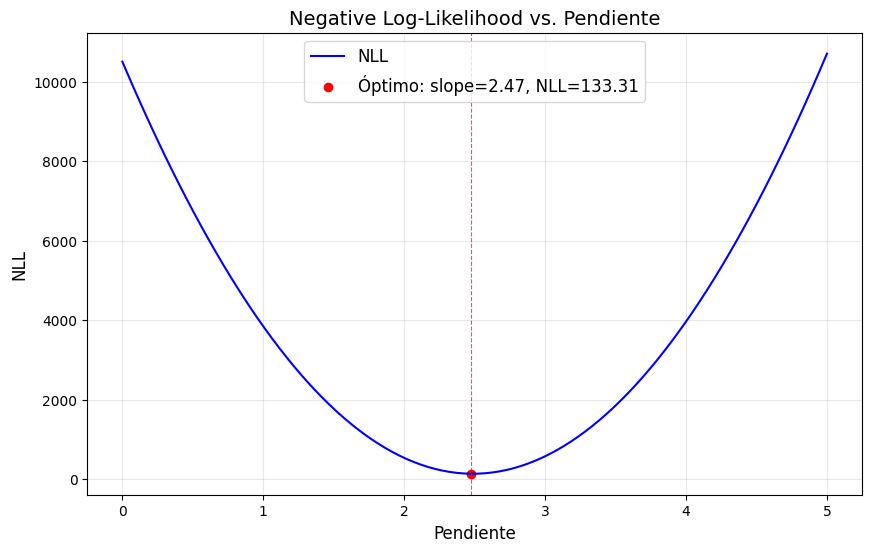

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Generar datos simulados
np.random.seed(42)
n = 100
x = np.linspace(0, 10, n)  # Variable independiente
true_intercept = 5
true_slope = 2.5
noise_std = 1.0
y = true_intercept + true_slope * x + np.random.normal(0, noise_std, n)

# Función para calcular el Negative Log-Likelihood
def nll(intercept, slope, sigma, x, y):
    residuals = y - (intercept + slope * x)
    n = len(y)
    nll =0.5 * n * np.log(2 * np.pi * sigma**2) + np.sum(residuals**2) / (2 * sigma**2)
    return nll

# Rango de valores para la pendiente (slope)
slope_range = np.linspace(0, 5, 100)  # Explorar pendientes entre 0 y 5
intercept_fixed = true_intercept  # Mantener el intercepto fijo
sigma_fixed = noise_std  # Mantener sigma fijo

# Calcular NLL para cada valor de la pendiente
nll_values = [nll(intercept_fixed, slope, sigma_fixed, x, y) for slope in slope_range]

# Encontrar el valor óptimo de la pendiente
optimal_index = np.argmin(nll_values)
optimal_slope = slope_range[optimal_index]
optimal_nll = nll_values[optimal_index]

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(slope_range, nll_values, label="NLL", color="blue")
plt.scatter(optimal_slope, optimal_nll, color="red", label=f"Óptimo: slope={optimal_slope:.2f}, NLL={optimal_nll:.2f}")
plt.axvline(optimal_slope, color="red", linestyle="--", linewidth=0.8, alpha=0.7)

# Etiquetas y leyenda
plt.title("Negative Log-Likelihood vs. Pendiente", fontsize=14)
plt.xlabel("Pendiente", fontsize=12)
plt.ylabel("NLL", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

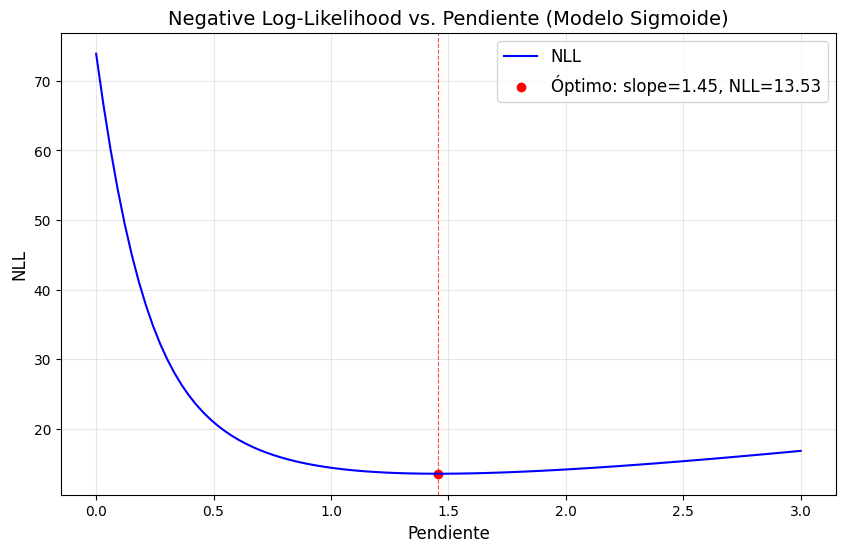

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Generar datos simulados para clasificación binaria
np.random.seed(42)
n = 100
x = np.linspace(-10, 10, n)  # Variable independiente
true_intercept = 0.5
true_slope = 1.5
sigmoid = lambda z: 1 / (1 + np.exp(-z))  # Función sigmoide

# Generar probabilidades verdaderas
y_prob = sigmoid(true_intercept + true_slope * x)

# Generar etiquetas binarias basadas en las probabilidades
y = np.random.binomial(1, y_prob)

# Función para calcular el Negative Log-Likelihood
def nll(intercept, slope, x, y):
    y_pred = sigmoid(intercept + slope * x)
    # Evitar log(0) ajustando valores muy cercanos a 0 o 1
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

# Rango de valores para la pendiente (slope)
slope_range = np.linspace(0, 3, 100)  # Explorar pendientes entre 0 y 3
intercept_fixed = true_intercept  # Mantener el intercepto fijo

# Calcular NLL para cada valor de la pendiente
nll_values = [nll(intercept_fixed, slope, x, y) for slope in slope_range]

# Encontrar el valor óptimo de la pendiente
optimal_index = np.argmin(nll_values)
optimal_slope = slope_range[optimal_index]
optimal_nll = nll_values[optimal_index]

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(slope_range, nll_values, label="NLL", color="blue")
plt.scatter(optimal_slope, optimal_nll, color="red", label=f"Óptimo: slope={optimal_slope:.2f}, NLL={optimal_nll:.2f}")
plt.axvline(optimal_slope, color="red", linestyle="--", linewidth=0.8, alpha=0.7)

# Etiquetas y leyenda
plt.title("Negative Log-Likelihood vs. Pendiente (Modelo Sigmoide)", fontsize=14)
plt.xlabel("Pendiente", fontsize=12)
plt.ylabel("NLL", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()